In [25]:
%run /home/grg/git/alfa/nilearn-helper.py
%matplotlib inline
%run /home/grg/git/alfa/roicollect.py

This collect the values from \*\_stats.csv files, i.e. values that have been extracted from ROI manually drawn in MNI space.
The bad thing with this is that the ROI is defined in a reference space. This is subject to individual registration errors.

{1: 'left_occip', 2: 'left_temporal', 3: 'left_temporal2', 4: 'right_perihorn', 5: 'left_occip2', 6: 'left_perihorn', 7: 'left_wm', 8: 'right_occip', 9: 'right_temporal', 10: 'left_insula'}
Standard deviation of label left_occip: 7.31820507353e-05
Model used for correction: roi ~ 1 + C(apo) + gender + educyears + ventricles
Standard deviation after correction for covariates: 7.18412163381e-05
Region: left_occip - Fitting order: 1 - Formula: roi ~ 1 + age
Standard deviation of label left_temporal: 8.02233710244e-05
Model used for correction: roi ~ 1 + C(apo) + gender + educyears + ventricles
Standard deviation after correction for covariates: 7.84503848669e-05
Region: left_temporal - Fitting order: 1 - Formula: roi ~ 1 + age
Standard deviation of label left_temporal2: 0.000125657175895
Model used for correction: roi ~ 1 + C(apo) + gender + educyears + ventricles
Standard deviation after correction for covariates: 0.000123440471918
Region: left_temporal2 - Fitting order: 1 - Formula: roi

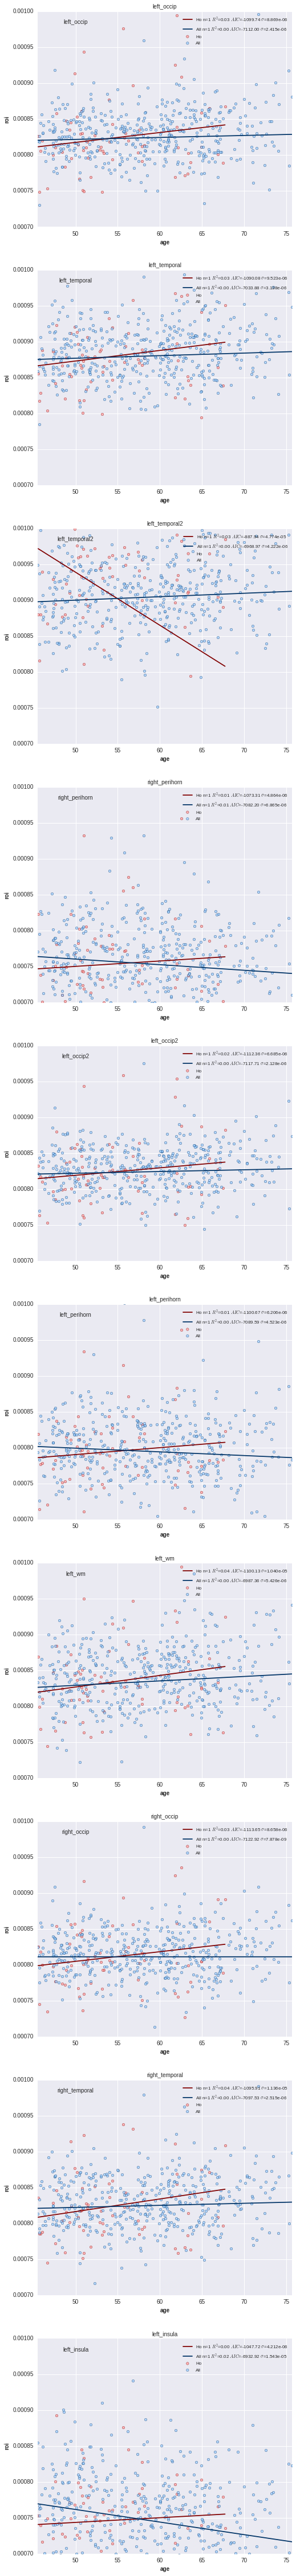

In [33]:
regions = range(1,11)
data = pd.read_excel('/tmp/covariates.xls')
data['subject'] = data.index
data = data.sort_values(['apo', 'subject'])
src = '/tmp/roivalues_csf.5/'
filepattern = '*_stats.csv'
csvfiles = glob(osp.join(src, filepattern))
subjects = [string.atoi(e.split('/')[-1].split('_')[0]) for e in csvfiles]
plot_regions(data, regions, csvfiles, subjects, groups=['HO','All'], ylim=[0.0007,0.001])

In [28]:
import plotly
#plotly.init_notebook_mode()

def plotly_region(roilabel):
    to_remove = [55166, 66159, 77068, 10182, 13059, 66019, 66264, 77024, 77263,
            10846, 66026, 66039, 66131, 66368, 77027, 77047]
    data = collect_data()
    roivalues = collect_roivalues(roilabel)
    #data = data[data['apo']==0]
    df = data.join(roivalues)
    df['subject'] = df.index
    #df = df.drop(to_remove)
    
    
    import plotly.plotly as py
    import plotly.graph_objs as go

    #data = [trace]

    # Plot and embed in ipython notebook!
    #

    trace = go.Scatter(
        x = df['age'],
        y = df['roi'],

        marker=dict(
            size='4',
            color = df['apo'], #set color equal to a variable
            colorscale='Jet',
            showscale=True),
        text = df['subject'],
        mode = 'markers'
    )

    data = [trace]

    # Plot and embed in ipython notebook!
    py.iplot(data)
    # or plot with: plot_url = py.plot(data, filename='basic-line')